In [1]:
import pandas 
import matplotlib
import matplotlib.pyplot as plt

In [2]:
tf_parameters = ['step', 'uBA','sbA','uBB','sbB','pA','pb','pc', 'pm','umax','nl',
                 'eLJ','uc','cost']
df_params = pandas.DataFrame(columns = tf_parameters)

In [3]:
# %load tf-optimizer.py
#from __future__ import absolute_import
#from __future__ import division
from __future__ import print_function

import pandas
import numpy as np
import random
from numpy.polynomial.hermite  import hermgauss
import tensorflow as tf

kT = 1.986e-3*300.0 #1/kT at 300K 
beta = 1./kT

xg,wg = hermgauss(15)
xgauss = np.float32(xg)
wgauss = np.float32(wg)
ngauss = xgauss.size


## Read in data
ulambda = pandas.read_csv("sampl4-oah-b7eqnosc.repl.cycle.totE.potE.temp.lambda.ebind.dat",delim_whitespace=True, 
                          header=None,names=["replica","cycle","totE",
                                             "potE","temp","Lambda","ebind"])

#ulambda = pandas.read_csv("bcd-nabumetone.repl",delim_whitespace=True, 
#                          header=None,names=["replica","cycle","totE",
#                          "potE","temp","Lambda","ebind"])




u = np.float32(ulambda['ebind'])*beta #transform in units of kT
lmbs = np.float32(ulambda['Lambda'])
cycles = np.int32(ulambda['cycle'])

#mask = np.logical_and(lmbs < 0.3 , lmbs > 1.e-3)
mask = np.logical_and(lmbs > 1.e-6, cycles > 100)
#mask = np.abs(lmbs - 0.1) < 1.e-6
un = u[mask]
ln = lmbs[mask]

#initial parameters
ubA = -13.953*beta
sbA = 1.906*beta
ubB = -2.334*beta
sbB = 3.238*beta
pA = 2.45e-4
pB = 1. - pA
elj = 20.0*beta # 20.0
uc = 0.5*beta
nl = 2.96 # 2.96
pb = 1.18e-4
pc = 3.00e-2
pm = 1. - pb - pc
umax = 1.e6*beta

#integration grid for Pwca
a = uc
ymax = np.log(umax)/a 
dy = ymax/100.0
xasymp = np.float32(np.exp(a*np.arange(0.,ymax,dy)) - 1.) + 1.e-6
dxasymp = np.float32(xasymp[1:] - xasymp[:-1])
nx = dxasymp.size
xasymp = np.float32(xasymp[:-1])

#dictionary of parameters
params = {}

params['UBA'] = tf.constant(ubA)
#params['UBA'] = tf.get_variable("UBA", initializer=tf.constant(ubA))

params['SIGBA'] = tf.constant(sbA)
#params['SIGBA'] = tf.get_variable("SIGBA", initializer=tf.constant(sbA))

params['UBB'] = tf.constant(ubB)
#params['UBB'] = tf.get_variable("UBB", initializer=tf.constant(ubB))

params['SIGBB'] = tf.constant(sbB)
#params['SIGBB'] = tf.get_variable("SIGBB", initializer=tf.constant(sbB))

params['PA'] =  tf.constant(pA)
#params['PA'] = tf.get_variable("PA", initializer=tf.constant(pA))

params['E'] = tf.constant(elj)
#params['E'] = tf.get_variable("E", initializer=tf.constant(elj))

params['UC'] = tf.constant(uc) #not optimize for now
#params['UC'] = tf.get_variable("UC", initializer=tf.constant(uc))

#params['NL'] =  tf.constant(nl)
params['NL'] =  tf.get_variable("NL", initializer=tf.constant(nl))

#params['PB'] =  tf.constant(pb)
params['PB'] = tf.get_variable("PB", initializer=tf.constant(pb))

#params['PC'] =  tf.constant(pc)
params['PC'] = tf.get_variable("PC", initializer=tf.constant(pc))



pi = tf.constant(np.pi)

ngauss_p = tf.constant(ngauss, dtype=tf.int32)
xgauss_p = tf.constant(np.float32(xgauss), dtype=tf.float32)
wgauss_p = tf.constant(np.float32(wgauss), dtype=tf.float32)

u_p = tf.constant(un, dtype=tf.float32)
lmbs_p = tf.constant(ln, dtype=tf.float32)

xasymp_p = tf.constant(xasymp, dtype=tf.float32)
dxasymp_p = tf.constant(dxasymp, dtype=tf.float32)
nx_p = tf.constant(nx, dtype=tf.int32)


pm_p = tf.constant(pm)

xc = tf.sqrt(params['UC']/params['E'])
a = tf.sqrt(1.+xc)
eps = xc/10.
xm = tf.sqrt(umax/params['E'])
nm = tf.pow(1. - params['NL']*a/xm, -1)

#Gaussian (mixture) for B for all input u's
gbA = tf.exp(-tf.pow(u_p-params['UBA'],2)/(2.0*tf.pow(params['SIGBA'],2)))/(tf.sqrt(2.*pi)*params['SIGBA'])
gbB = tf.exp(-tf.pow(u_p-params['UBB'],2)/(2.0*tf.pow(params['SIGBB'],2)))/(tf.sqrt(2.*pi)*params['SIGBB'])
gb1 = params['PA']*gbA + gbB - params['PA']*gbB

#gaussian at large distance pB(u - umax)
gbAfar = tf.exp(-tf.pow(u_p-umax-params['UBA'],2)/(2.0*tf.pow(params['SIGBA'],2)))/(tf.sqrt(2.*pi)*params['SIGBA'])
gbBfar = tf.exp(-tf.pow(u_p-umax-params['UBB'],2)/(2.0*tf.pow(params['SIGBB'],2)))/(tf.sqrt(2.*pi)*params['SIGBB'])
gbfar = params['PA']*gbAfar + gbBfar - params['PA']*gbBfar


#convolution of gaussian (mixture) and pwca
sq2 = tf.sqrt(2.)
#Pwca for all input y's
yA = sq2*params['SIGBA']*xgauss_p + u_p[:,None] - params['UBA']
x1A = tf.pow(yA/params['E'],2) #to make x positive
xA  = tf.pow( x1A , 0.25 )
bA = tf.sqrt(1.+ xA)
z1A = tf.tanh( tf.pow(a/bA,12.) )
zA = tf.pow( z1A, 1./12. ) #caps z to 1
fcore2A = tf.pow((1.-zA), params['NL']-1.)
fcore3A = a/((xA+eps)*tf.pow(bA,3)*4.*params['E'])
fcore4A = tf.sigmoid(20.*(yA-0.5*params['UC'])/params['UC'])
pwcaA = nm*params['NL']*fcore2A*fcore3A*fcore4A
#---
qA = tf.matmul(pwcaA,tf.reshape(wgauss_p,[ngauss_p,1]))/tf.sqrt(pi)
q2A = qA[:,0]

yB = sq2*params['SIGBB']*xgauss_p + u_p[:,None] - params['UBB']
x1B = tf.pow(yB/params['E'],2) #to make x positive
xB  = tf.pow( x1B , 0.25 )
bB = tf.sqrt(1.+ xB)
z1B = tf.tanh( tf.pow(a/bB,12.) )
zB = tf.pow( z1B, 1./12. ) #caps z to 1
fcore2B = tf.pow((1.-zB), params['NL']-1.)
fcore3B = a/((xB+eps)*tf.pow(bB,3)*4.*params['E'])
fcore4B = tf.sigmoid(20.*(yB-0.5*params['UC'])/params['UC'])
pwcaB = nm*params['NL']*fcore2B*fcore3B*fcore4B
#---
qB = tf.matmul(pwcaB,tf.reshape(wgauss_p,[ngauss_p,1]))/tf.sqrt(pi)
q2B = qB[:,0]

q2 = params['PA']*q2A + q2B - params['PA']*q2B

#p0's
p0 = params['PB']*gb1 + params['PC']*q2 + pm_p*gbfar

#kB1
klBA = tf.exp(0.5*tf.pow(params['SIGBA'],2)*tf.pow(lmbs_p,2) - lmbs_p*params['UBA'])
klBB = tf.exp(0.5*tf.pow(params['SIGBB'],2)*tf.pow(lmbs_p,2) - lmbs_p*params['UBB']) 
klB1 = params['PA']*klBA + klBB - params['PA']*klBB

#pwca for the x grid
x1_s = tf.pow(xasymp_p/params['E'],2) #to make x positive
x_s  = tf.pow( x1_s , 0.25 )
b_s = tf.sqrt(1.+ x_s)
z1_s = tf.tanh( tf.pow(a/b_s,12.) )
z_s = tf.pow( z1_s, 1./12. ) #caps z to 1
fcore2_s = tf.pow((1.-z_s), params['NL']-1.)
fcore3_s = a/((x_s+eps)*tf.pow(b_s,3)*4.*params['E'])
fcore4_s = tf.sigmoid(20.*(xasymp_p-0.5*params['UC'])/params['UC'])
pwca_s = nm*params['NL']*fcore2_s*fcore3_s*fcore4_s

#kwca
fsamples = dxasymp_p*pwca_s
expl = tf.exp(- xasymp_p * lmbs_p[:,None])
q_C = tf.matmul(expl,tf.reshape(fsamples,[nx_p,1]))
klwca = q_C[:,0]

#free energies
e2 = tf.exp(-umax * lmbs_p)
klC = params['PB'] + e2 - params['PC']*e2 - params['PB']*e2 + params['PC'] * klwca
kl = klB1*klC
pkl = p0/kl

#cost function
cost = -tf.reduce_sum(tf.log(pkl))
    
optimizer = tf.train.AdamOptimizer(2.e-4)
#optimizer = tf.train.GradientDescentOptimizer(5.e-6)
train = optimizer.minimize(cost)

init = tf.global_variables_initializer()

gradient_cost = optimizer.compute_gradients(cost)

sess = tf.Session()

sess.run(init)

ll = sess.run(cost)
print("starting at x:", " uBA =", ubA*kT, "sbA =", sbA*kT, " uBB =", ubB*kT, "sbB =", sbB*kT, "pA =", pA, "pb = ", pb, "pc =", pc, "pm = ", pm, "umax = ", umax, "nl = ", nl, "eLJ = ", elj*kT, "uc = ", uc*kT)
print("cost:", ll)
print(sess.run(gradient_cost))

best_loss = ll
best_ubA = sess.run(params['UBA'])
best_sbA = sess.run(params['SIGBA'])
best_ubB = sess.run(params['UBB'])
best_sbB = sess.run(params['SIGBB'])
best_pA = sess.run(params['PA'])
best_pb = sess.run(params['PB'])
best_pc = sess.run(params['PC'])
best_nl = sess.run(params['NL'])
best_elj = sess.run(params['E'])
best_uc = sess.run(params['UC'])   
for step in range(100):
      sess.run(train)
      ll = sess.run(cost)
      lubA = sess.run(params['UBA'])
      lsbA = sess.run(params['SIGBA'])
      lubB = sess.run(params['UBB'])
      lsbB = sess.run(params['SIGBB'])
      lpA =  sess.run(params['PA'])
      lpb = sess.run(params['PB'])
      lpc = sess.run(params['PC'])
      lnl = sess.run(params['NL'])
      lelj = sess.run(params['E'])
      luc = sess.run(params['UC'])                     
      if( ll < best_loss ):
          best_loss = ll
          best_ubA = lubA
          best_sbA = lsbA
          best_ubB = lubB
          best_sbB = lsbB
          best_pA = lpA
          best_pb = lpb
          best_pc = lpc
          best_nl = lnl
          best_elj = lelj
          best_uc = luc
      #print("step", step, "x:", " uBA =", lubA*kT, "sbA =", lsbA*kT, " uBB =", lubB*kT, "sbB =", lsbB*kT, "pA = ", lpA, "pb = ", lpb, "pc =", lpc, "pm = ", pm, "umax = ", umax, "nl = ", lnl, "eLJ = ", lelj*kT, "uc = ", luc*kT, "cost =", ll)
      #print(sess.run(gradient_cost))
      df_params = df_params.append({'step':step,'uBA':lubA*kT,'sbA':lsbA*kT,
                                           'uBB':lubB*kT,'sbB':lsbB*kT,'pA':lpA,'pb':lpb,
                                           'pc':lpc,'pm':pm,'umax':umax,'nl':lnl,'eLJ':lelj*kT,
                                           'uc':luc*kT,'cost':ll},ignore_index=True)

print("----- End of optimization --------");
print("best", "x:", " uBA =", best_ubA*kT, "sbA =", best_sbA*kT, "uBB =", best_ubB*kT, "sbB =", best_sbB*kT, "pA =", best_pA, "pb = ", best_pb, "pc =", best_pc, "pm = ", pm, "umax = ", umax, "nl = ", best_nl, "eLJ = ", best_elj*kT, "uc = ", best_uc*kT, "cost =", best_loss)


starting at x:  uBA = -13.953 sbA = 1.906  uBB = -2.334 sbB = 3.238 pA = 0.000245 pb =  0.000118 pc = 0.03 pm =  0.969882 umax =  1678415.5756965424 nl =  2.96 eLJ =  20.0 uc =  0.5
cost: 128296.33
[(-232.87845, 2.96), (-46828.0, 0.000118), (184.1236, 0.03)]
----- End of optimization --------
best x:  uBA = -13.952999662399291 sbA = 1.90600006814003 uBB = -2.3340000610828397 sbB = 3.2379999492645264 pA = 0.000245 pb =  0.00012045106 pc = 0.030114805 pm =  0.969882 umax =  1678415.5756965424 nl =  2.96014 eLJ =  19.9999989692688 uc =  0.4999999884366989 cost = 128296.28


In [4]:
df_params.head()

,step,uBA,sbA,uBB,sbB,pA,pb,pc,pm,umax,nl,eLJ,uc,cost
0,0.0,-13.953,1.906,-2.334,3.238,0.000245,0.000318,0.029800,0.969882,1.678416e+06,2.960200,19.999999,0.5,128575.875000
1,1.0,-13.953,1.906,-2.334,3.238,0.000245,0.000173,0.029948,0.969882,1.678416e+06,2.960131,19.999999,0.5,128332.804688
2,2.0,-13.953,1.906,-2.334,3.238,0.000245,0.000010,0.030096,0.969882,1.678416e+06,2.960076,19.999999,0.5,129267.093750
3,3.0,-13.953,1.906,-2.334,3.238,0.000245,0.000120,0.030115,0.969882,1.678416e+06,2.960140,19.999999,0.5,128296.281250
4,4.0,-13.953,1.906,-2.334,3.238,0.000245,0.000214,0.030131,0.969882,1.678416e+06,2.960221,19.999999,0.5,128388.296875


In [5]:
df_params.tail()

,step,uBA,sbA,uBB,sbB,pA,pb,pc,pm,umax,nl,eLJ,uc,cost
95,95.0,-13.953,1.906,-2.334,3.238,0.000245,0.000147,0.037577,0.969882,1.678416e+06,2.958118,19.999999,0.5,128296.757812
96,96.0,-13.953,1.906,-2.334,3.238,0.000245,0.000149,0.037576,0.969882,1.678416e+06,2.958226,19.999999,0.5,128296.726562
97,97.0,-13.953,1.906,-2.334,3.238,0.000245,0.000151,0.037574,0.969882,1.678416e+06,2.958334,19.999999,0.5,128296.695312
98,98.0,-13.953,1.906,-2.334,3.238,0.000245,0.000152,0.037573,0.969882,1.678416e+06,2.958442,19.999999,0.5,128296.718750
99,99.0,-13.953,1.906,-2.334,3.238,0.000245,0.000153,0.037572,0.969882,1.678416e+06,2.958550,19.999999,0.5,128296.742188


In [6]:
df_params.describe()

,step,uBA,sbA,uBB,sbB,pA,pb,pc,pm,umax,nl,eLJ,uc,cost
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,1.000000e+02,100.000000
mean,49.500000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.000249,0.035538,9.698820e-01,1.678416e+06,2.956758,19.999999,5.000000e-01,128467.246172
std,29.011492,5.355917e-15,2.231632e-16,4.463264e-16,4.463264e-16,0.000000,0.000162,0.002587,1.115816e-16,4.680072e-10,0.001840,0.000000,5.579081e-17,259.544521
min,0.000000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.000010,0.029800,9.698820e-01,1.678416e+06,2.954426,19.999999,5.000000e-01,128296.281250
25%,24.750000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.000144,0.033872,9.698820e-01,1.678416e+06,2.955099,19.999999,5.000000e-01,128298.091797
50%,49.500000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.000164,0.036954,9.698820e-01,1.678416e+06,2.956442,19.999999,5.000000e-01,128310.421875
75%,74.250000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.000347,0.037499,9.698820e-01,1.678416e+06,2.958041,19.999999,5.000000e-01,128585.947266
max,99.000000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.000590,0.037580,9.698820e-01,1.678416e+06,2.960273,19.999999,5.000000e-01,129267.093750


In [7]:
df_cost = df_params[['step','cost']]
df_cost.tail()

,step,cost
95,95.0,128296.757812
96,96.0,128296.726562
97,97.0,128296.695312
98,98.0,128296.718750
99,99.0,128296.742188


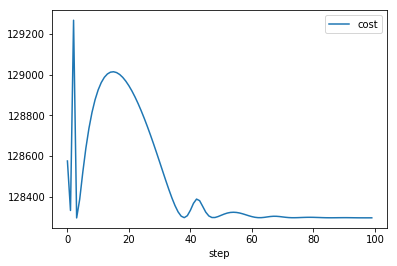

In [8]:
df_cost.plot(kind='line',x='step',y='cost')

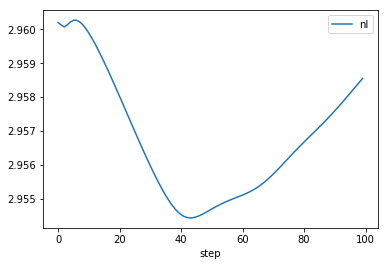

In [12]:
df_params.plot(kind='line',x='step',y='nl')

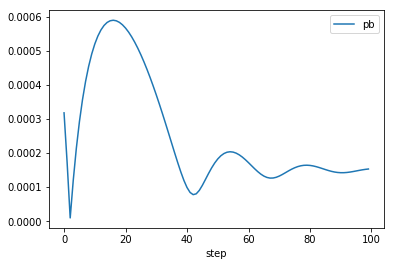

In [14]:
df_params.plot(kind='line',x='step',y='pb')

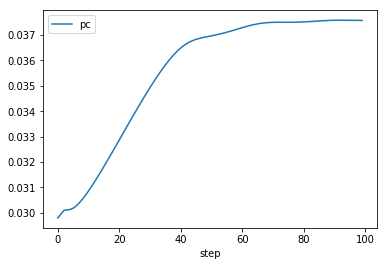

In [15]:
df_params.plot(kind='line',x='step',y='pc')